In [1]:
%load_ext rpy2.ipython

In [96]:
%%R
library(dplyr); library(tidyr)
library(magrittr)
library(ggplot2)
library(phyloseq)
library(DESeq2)

In [24]:
%%R
FDR = 0.10

rspndrs = read.csv("../data/l2fc_table.csv", stringsAsFactors = FALSE) %>%
    filter(test == "greater", p.adj <= FDR) %>%
    select(OTU) %>% extract2(1) %>% unique

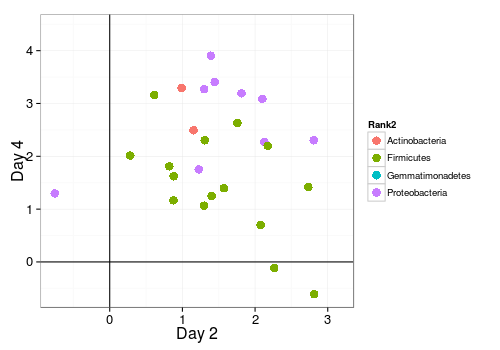

In [44]:
%%R -w 500 -h 350
d = read.csv("../data/l2fc_table.csv", stringsAsFactors = FALSE) %>%
    filter(OTU %in% rspndrs, test == "greater") %>%
    select(OTU, Rank2, day, log2FoldChange) %>%
    spread(day, log2FoldChange)

p = ggplot(d, aes(x = `2`, y = `4`, color = Rank2))

p = p + geom_hline(xintercept = 0)

p = p + geom_vline(yintercept = 0)

p = p + geom_point(size = 4)

p = p + labs(x = "Day 2", y = "Day 4")

p = p + theme_bw()

p = p + theme(axis.text = element_text(size = 13),
              axis.title = element_text(size = 16))

p

In [118]:
%%R
otus = read.csv("../data/l2fc_table.csv", stringsAsFactors = FALSE) %>%
    select(OTU) %>% extract2(1) %>% unique

physeq = import_biom("../data/otu_table_wtax.biom")
md = read.table("../data/barcode_mapper.txt", 
                sep = "\t", 
                header = TRUE,
                comment = "")
rownames(md) = md$X.SampleID
md$DayCollected %<>% factor
sample_data(physeq) = sample_data(md)
sd = sample_data(physeq)

density.min = 1.725

physeq = prune_samples(sd$Density >= density.min, physeq)

TT = data.frame(tax_table(physeq))
TT$OTU = rownames(TT)

physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4340 taxa and 36 samples ]
sample_data() Sample Data:       [ 36 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 4340 taxa by 8 taxonomic ranks ]


In [98]:
%%R
dds = phyloseq_to_deseq2(physeq, ~Treatment*factor(DayCollected))
dds = DESeq(dds)
res.int = data.frame(results(dds, independentFiltering = FALSE, cooksCutoff = FALSE))
res.int$OTU = rownames(res)

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
NOTE: fitType='parametric', but the dispersion trend was not well captured by the
  function: y = a/x + b, and a local regression fit was automatically substituted.
  specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 2 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


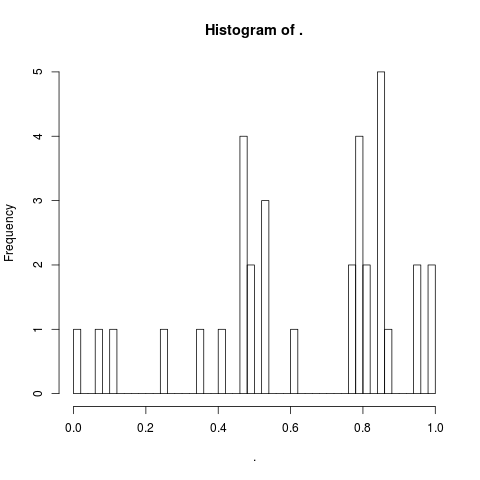

In [99]:
%%R
res.int %>%
    filter(OTU %in% otus) %>%
    mutate(p.adj = p.adjust(pvalue, method = "BH")) %>%
    filter(OTU %in% rspndrs) %>%
    select(p.adj) %>% extract2(1) %>% hist(breaks = 50)

In [121]:
%%R
FDR = 0.10

res.int %>%
    filter(OTU %in% otus) %>%
    left_join(TT) %>%
    mutate(p.adj = p.adjust(pvalue, method = "BH")) %>%
    filter(OTU %in% rspndrs) %>% 
    select(OTU, p.adj, Rank2, Rank3) %>%
    filter(p.adj <= FDR)

Joining by: "OTU"
       OTU      p.adj      Rank2      Rank3
1  OTU.227 0.01600450 Firmicutes Clostridia
2 OTU.4037 0.06604938 Firmicutes Clostridia


In [100]:
%%R
dds = phyloseq_to_deseq2(physeq, ~Treatment)
dds = DESeq(dds)
res = data.frame(results(dds, independentFiltering = FALSE, cooksCutoff = FALSE))
res$OTU = rownames(res)

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
NOTE: fitType='parametric', but the dispersion trend was not well captured by the
  function: y = a/x + b, and a local regression fit was automatically substituted.
  specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 29 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [113]:
%%R
FDR = 0.10

TT = data.frame(tax_table(physeq))
TT$OTU = rownames(TT)

res %>%
    filter(OTU %in% otus) %>%
    left_join(TT) %>%
    mutate(p.adj = p.adjust(pvalue, method = "BH")) %>%
    filter(OTU %in% rspndrs) %>%
    select(OTU, p.adj, Rank2, Rank3) %>%
    filter(p.adj > FDR)

Joining by: "OTU"
      OTU     p.adj          Rank2               Rank3
1 OTU.137 0.2816118 Proteobacteria Alphaproteobacteria
2 OTU.227 0.7062822     Firmicutes          Clostridia
3 OTU.263 0.1687971 Proteobacteria Alphaproteobacteria
